<a href="https://colab.research.google.com/github/rtedwards/nn-zero-to-hero/blob/main/3_makemore_bn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Batch Normalization

In [ ]:
import random

import altair as alt
import pandas as pd
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm.notebook import tqdm

In [ ]:
words = open("names.txt", "r").read().splitlines()

In [ ]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set("".join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi["."] = 0
itos = {i:s for s, i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


## I. Build Dataset

In [ ]:
def build_dataset(words, block_size = 3):
    """
    - block_size - context length: how many characters fo we take to predict the next one?
    """
    X, Y = [], []
    for w in words:
        context = [0] * block_size
        for ch in w + ".":
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)

            context = context[1:] + [ix] # crop and append

    X = torch.tensor(X)
    Y = torch.tensor(Y)

    print(X.shape, Y.shape)
    return X, Y

## II. Data set Splits

- Training (80%) - used to optimize the model parameters
- Validation (10%) - used to optimize the model hyperparameters(number of neurons, size of hidden layer, size of embedding, strength of regularization)
- Test (10%) - used to evaluate model as it generalizes to unseen data

In [ ]:
# train / validation / test splits
random.seed(42)
random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))
block_size = 3 # number of previous characters

X_train, Y_train = build_dataset(words[:n1], block_size)
X_val, Y_val = build_dataset(words[n1:n2], block_size)
X_test, Y_test = build_dataset(words[n2:], block_size)

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


## III. Initialize Network (MLP)

In [ ]:
n_embd = 10 # number of dimensions in embeddings
fan_in = block_size * n_embd
n_hidden = 200

g = torch.Generator().manual_seed(2147483647)           # for reproducability
C = torch.randn((vocab_size, n_embd),       generator=g)        # block_size embeddings
W1 = torch.randn((fan_in, n_hidden),        generator=g) * (5/3) / (fan_in**0.5)  # kaiming initialization - https://pytorch.org/docs/stable/nn.init.html#torch.nn.init.kaiming_uniform_
# b1 = torch.randn(n_hidden,                  generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size),    generator=g) * 0.01  # make W small so loss is smaller
b2 = torch.randn(vocab_size,                generator=g) * 0.0  # removes initial bias

# Batch Normalization parameters
bn_gain = torch.ones((1, n_hidden))
bn_bias = torch.zeros((1, n_hidden))
bn_mean_running = torch.zeros((1, n_hidden))
bn_std_running = torch.ones((1, n_hidden))
parameters = [C, W1, W2, b2, bn_gain, bn_bias] # b1 (remove bias b/c BN will subtract it out)

for p in parameters:
    p.requires_grad = True

print(f"Num parameters: {sum(p.nelement() for p in parameters)}")

Num parameters: 12097


## IV. Training

In [ ]:
n_iters = 200_000
batch_size = 32 # minibatch construct of 32 examples

loss_i = []
step_i = []

for i in tqdm(range(n_iters)):
    # minibatch construct
    ix = torch.randint(0, X_train.shape[0], (batch_size,), generator=g)
    Xb, Yb = X_train[ix], Y_train[ix]

    # Forward Pass
    emb = C[Xb] # embed the characters into vectors
    embcat = emb.view(emb.shape[0], -1) # concatenate the vectors

    # Linear Layer
    hpreact = embcat @ W1 # + b1          # hidden layer pre-activation (remove bias b/c BN will subtract it out)

    # Batch Normalization Layer
    # -------------------------
    eps = 1e-5
    bn_mean_i = hpreact.mean(0, keepdims=True)
    bn_std_i  = hpreact.std(0, keepdims=True)
    hpreact_norm = (hpreact - bn_mean_i) / (bn_std_i + eps)     # normalization
    hpreact_norm = bn_gain * hpreact_norm + bn_bias     # scale and shift

    # running statistics
    with torch.no_grad():
        bn_mean_running = 0.999 * bn_mean_running + 0.001 * bn_mean_i
        bn_std_running = 0.999 * bn_std_running + 0.001 * bn_std_i
    # -------------------------

    # Non-linearity
    h = torch.tanh(hpreact_norm)        # hidden layer
    logits = h @ W2 + b2                # output layer
    loss = F.cross_entropy(logits, Yb)  # loss function

    # Backward Pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # Update
    lr = 0.1 if i < 100_000 else 0.01 # learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

    # Track Stats
    step_i.append(i)
    loss_i.append(loss.log10().item())

    # break
print(f"minibatch loss: {loss.item()}")

  0%|          | 0/200000 [00:00<?, ?it/s]

minibatch loss: 2.0136284828186035


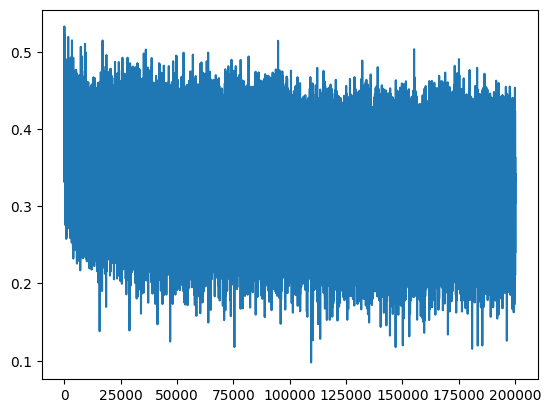

In [ ]:
plt.plot(step_i, loss_i)

In [ ]:
@torch.no_grad() # disables gradient tracking
def split_loss(split):
    x,y = {
        "train": (X_train, Y_train),
        "validation": (X_val, Y_val),
        "test": (X_test, Y_test),
    }[split]

    emb = C[x] # (N, block_size, n_embd)
    embcat = emb.view(emb.shape[0], -1) # concate into (N, block_size * n_embd)
    hpreact = embcat @ W1 + b1

    # Batch Normalization
    hpreact_norm = (hpreact - bn_mean_running) / bn_std_running # normalization
    hpreact_norm = bn_gain * hpreact_norm + bn_bias             # scale and shift

    h = torch.tanh(hpreact_norm) # (N, n_hidden)

    logits = h @ W2 + b2 # (N, vocab_size)
    loss = F.cross_entropy(logits, y)
    print(f"{split}: {loss.item()}")

split_loss("train")
split_loss("validation")

train: 2.0674192905426025
validation: 2.105670928955078


## V. Inference

In [ ]:
def generate_name(generator):
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
        # forward pass the nerual net
        emb = C[torch.tensor([context])] # (1, block_size, n_emb)
        embcat = emb.view((emb.shape[0], -1)) # concatenate vectors
        hpreact = embcat @ W1 #+ b1

        # Batch Normalization
        hpreact_norm = (hpreact - bn_mean_running) / bn_std_running # normalization
        hpreact_norm = bn_gain * hpreact_norm + bn_bias             # scale and shift

        h = torch.tanh(hpreact_norm)        # hidden layer
        logits = h @ W2 + b2                # output layer
        probs = F.softmax(logits, dim=1)

        # sample from distribution
        ix = torch.multinomial(probs, num_samples=1, generator=generator).item()

        # shift the context window and track the samples
        context = context[1:] + [ix]
        out.append(ix)

        # if we sample the special '.' token, break
        if ix == 0:
            break

    # decode and print the generated word
    return "".join(itos[i] for i in out)

In [ ]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    name = generate_name(g)
    print(name)


erbujgmyazzhzevvndhfyalwqetvrsjejdrljg.
ozcjedoeliihsmpqppalekepxvqnwxarqeptzcmhvqrpcn.
szdbvrgxhgmjestqjcjrwjkjqqxntpucfkubzmgvdcrxyqqufmehg.
kmejqvskkydmzhjl.
cakyybsufpzbjglvjurenjcrtvwsvevoeczpfhdxjfqyxoeobhggpcixjsfcueywhkhmrjolvii.
qirffevpkxwvlla.
odtabfsztpndgoikvsbmitgfkxvbssivpu.
meewrkepxcmvyhxavttudkjgczekhgcgtipvtudw.
iwbdnihzvorlq.
cjakepxugniagcfpppfmiipzjgvonxet.
jydnblkskzporygnogsvmwosfzybsyknvmjcxtkncjbmu.
jtew.
aow.
copmrlxkzdcqbcep.
ccdfivsnicimhtecmokfgouwzlrurdckappomtcokwxtnbnzkdphfam.
xcojfffuncxzhosyjsj.
ascnpc.
cilwtanczhrdtebimm.
ynw.
luzjaghwehtvggujbklwvofjiuzx.


# Notes
- use [torch.nn.init.kaiming_uniform_()](https://pytorch.org/docs/stable/nn.init.html#torch.nn.init.kaiming_uniform_) to initialize weights
- non-linear layers (e.g. tanh, sigmoid, ReLu) allow turn a sandwhich of lienar functions (Linear layers) into a nueral network that can approximate any aribitrary function.
- if ratio of gradients to data (`grad:data`) is too large, there's some trouble going on

## Loss Log

|                                | Train | Validation |
|--------------------------------|-------|------------|
| Original                       | 2.12  | 2.17       |
| Fix Softmax                    | 2.07  | 2.13       |
| Fix `tanh` Saturation          | 2.04  | 2.10       |
| Semi-Principled "kaiming init" | 2.04  | 2.17       |
| Batch Normalization            | 2.08  | 2.13       |
| Batch Normalization (flexible) | 2.07  | 2.10       |

- Original - from 1_makemore_mlp
- Fix Softmax - The softmax was confidently wrong.  We fixed this by zeroing the bias `b2` and squashing the weights `W2`.
- Fix `tanh` Saturation - The `tanh` was too saturated at initialization creating too many dead neurons.  We fixed this by squashing `hpreact` so that the values coming out of `tanh` are well-behaved (more uniformly distributed histogram rather than only extremes of `(-1, 1)`).  We do this by squashing `b1` and `W1`.
- These problems begin to stack with more layers in the neural network.

## Initial Bias and Training
If loss starts off high initially (graph looks like hocky stick), it means there was an initial bias in the weights that throws off the logits.  We can zero `b2` and squash the weights (make `W2` small) to offset this.

## Vanishing Gradients of `h`

1. We can see from the histogram that the `tanh` is very activate because most values are either `-1.0` or `1.0`.
2. This is because the distribution of preactivation is quite broad (-20, 20)
3. During backpropagation, if `tanh` is in the flat region (-1.0 or 1.0) the gradient will be zero.  This means the neuron will just pass gradients through it and will not learn.
    - can happen by chance during initialization that the weights and biases initialize dead neurons
    - can occur during optimization.  If learning rate is too large some neurons could have too large of a gradient and get knocked out of the data manifold.  Will remain dead forever.
    - Activation functions affected - any with flat regions: `tanh`, `sigmoid`, `ReLU`, `ELU`
    - to fix, we want `preact` closer to zero

$$
\begin{align}
\tanh(x) &= \frac{e^{2x} - 1}{e^{2x} + 1} \\
\frac{d}{dx}\tanh(x) &= 1 - \tanh^2(x)
\end{align}
$$

</br>
where $\tanh(x) = -1$ or $\tanh(x) = 1$
</br>

$$
\begin{align}
\frac{d}{dx}\tanh(x) &= 1 - \tanh^2(x) \\
&= 1 - (-1)^2 \\
&= 0
\\
\frac{d}{dx}\tanh(x) &= 1 - \tanh^2(x) \\
&= 1 - (1)^2 \\
&= 0
\end{align}
$$

### 1. tanh values

We can see from the histogram that the `tanh` is very activate because most values are either `-1.0` or `1.0`.

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_figwidth(10)
fig.set_figheight(3)

ax1.hist(h.view(-1).tolist(), 100);
ax1.set_title("`h`")
ax2.hist(hpreact.view(-1).tolist(), 100);
ax2.set_title("`hpreact`")

below, we can see the 32 examples with the 200 neurons
- white means the neuron was "active" where the tanh value > 0.99
- dead neuron - if a column is all white, the neuron is active for all examples then it will never learn

In [ ]:
plt.figure(figsize=(10, 20))
plt.imshow(h.abs() > 0.99, cmap="gray", interpolation="nearest")

### 2. Vanishing `tanh` gradients

- During backpropagation, if `tanh` is -1.0 or 1.0 (flat region) the gradient will be near zero.
- The gradients passing through the neuron in the graph will just be passed through because $\text{self.grad} += (1 - \approx 0^2) * \text{out.grad}$

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_figwidth(10)
fig.set_figheight(3)

# tanh(x)
x_values = torch.linspace(-3.0, 3.0, 100)
y_values = torch.tanh(x_values)
ax1.plot(x_values, y_values)
ax1.set_title("tanh(x)")

#tanh'(x)
y_values = 1 - torch.tanh(x_values)**2
ax2.plot(x_values, y_values)
ax2.set_title("tanh'(x)")

## Batch Normalization
- [Batch Normalization: Accelerating Deep Network Training by Reducing Internal Covariate Shift](https://arxiv.org/abs/1502.03167)
- Pros:
    - stabilizes training - controls distributions of activations
    - regularizing effect
    - allows training deeper neural nets
- Cons:
    - couples examples to other in the batch

Just using batch normalization of $\frac{x_i - \bar{x}}{\sigma^2(x)}$ will not acheive good results.  We want it to be roughly Guassian, but only at initialization.  We don't want to force the activation to always be Guassian.  We'd like to allow the neural net to move it around, to make it more diffuse (wider) or more sharp (narrower).  We want to let the backpropagation to tell it how to move around.  We can allow this by adding a scale factor, $\gamma$, and gain, $\beta$:

$$
y_i \leftarrow \gamma \widehat{x}_i + \beta \equiv \text{BN}_{\gamma,\beta} (x_i)
$$

If we set
- $\gamma = 1$
- $\beta = 0$

$$
y_i \leftarrow 1 \widehat{x}_i + 0 \equiv \text{BN}_{\gamma,\beta} (x_i)
$$

then at initialization, each neuron's firing value, `h`, in this batch will be exactly unit Guassian and will have "nice" numbers regardless of distribution of `hpreact`.  Then during backpropagation, $\gamma$ and $\beta$ will adjust with the network as needed.

**Tips:**
- Append a Batch Normalization layer right after a Linera Layer or Convolutional Layer to control the scale of the activations throught the neural net
- batch normalization couples the examples in each batch.  The hidden preactivations are going to change slightly depending on which other randomly samples examples are in the same batch.  `h` and `logits` will jitter.  This acts as a regularization by introducing entropy, which makes it more difficult for the neural net to overfit.
- Batch Normalization with subtley remove any biases in linear layers because any bias `b1` added will be removed when the mean $\bar{x}$ is subtracted.  This means we're wasting CPU cycles including a bias.  Best to remove from initialization.  The BN bias `bn_bias` becomes responsible for handling the bias.
- Momentum:
    - set momentum lower if using a small batch (e.g. 32 examples with momentum 0.001).  If set too high, the mean and std will not converge properly
    - set momentum higher if using a large batch (e.g. 256 examples with momentum 0.1)

Normalizations that do no couple examples in a batch:
    - linear normalization
    - instance normalization
    - group normalization

# Torchifying the Code

In [ ]:
class Linear:

    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out), generator=g) / fan_in**0.5
        self.bias = torch.zeros(fan_out) if bias else None

    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out

    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])


class BatchNorm1d:

    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        # parameters (trained with backprop)
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        # buffers (trained with a running 'momentum update')
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)

    def __call__(self, x):
        # calculate the forward pass
        if self.training:
            xmean = x.mean(0, keepdim=True) # batch mean
            xvar = x.var(0, keepdim=True) # batch variance
        else:
            xmean = self.running_mean
            xvar = self.running_var
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
        self.out = self.gamma * xhat + self.beta

        # update the buffers
        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
        return self.out

    def parameters(self):
        return [self.gamma, self.beta]

class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out

    def parameters(self):
        return []

In [ ]:
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 100 # the number of neurons in the hidden layer of the MLP
g = torch.Generator().manual_seed(2147483647) # for reproducibility

C = torch.randn((vocab_size, n_embd),            generator=g)
layers = [
    Linear(n_embd * block_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(           n_hidden, vocab_size, bias=False), BatchNorm1d(vocab_size),
]

# layers = [
#   Linear(n_embd * block_size, n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden), Tanh(),
#   Linear(           n_hidden, vocab_size),
# ]

with torch.no_grad():
    # last layer: make less confident
    layers[-1].gamma *= 0.1 # makes the activation of the last layer (softmax) less confident
    # layers[-1].weight *= 0.1 #
    # all other layers: apply gain
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= 1.0 #5/3

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
    p.requires_grad = True

47024


In [ ]:
# same optimization as last time
max_steps = 200_000
batch_size = 32
lossi = []
ud = []

for i in tqdm(range(max_steps)):

    # minibatch construct
    ix = torch.randint(0, X_train.shape[0], (batch_size,), generator=g)
    Xb, Yb = X_train[ix], Y_train[ix] # batch X,Y

    # forward pass
    emb = C[Xb] # embed the characters into vectors
    x = emb.view(emb.shape[0], -1) # concatenate the vectors
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, Yb) # loss function

    # backward pass
    for layer in layers:
        layer.out.retain_grad() # AFTER_DEBUG: would take out retain_graph
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 150000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i % 10000 == 0: # print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    with torch.no_grad():
        ud.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in parameters])

    # if i >= 1000:
    #     break # AFTER_DEBUG: would take out obviously to run full optimization

  0%|          | 0/200000 [00:00<?, ?it/s]

      0/ 200000: 3.2870
  10000/ 200000: 2.3273
  20000/ 200000: 2.1019
  30000/ 200000: 1.9020
  40000/ 200000: 2.1643
  50000/ 200000: 2.1520
  60000/ 200000: 1.7767
  70000/ 200000: 2.1514
  80000/ 200000: 2.3802
  90000/ 200000: 1.9338
 100000/ 200000: 2.3943
 110000/ 200000: 2.1507
 120000/ 200000: 2.1813
 130000/ 200000: 2.0889
 140000/ 200000: 1.8096
 150000/ 200000: 1.9133
 160000/ 200000: 1.9793
 170000/ 200000: 1.9654
 180000/ 200000: 2.2462
 190000/ 200000: 1.9601


layer 2 (      Tanh): mean +0.01, std 0.70, saturated: 17.69%
layer 5 (      Tanh): mean -0.02, std 0.75, saturated: 21.62%
layer 8 (      Tanh): mean +0.01, std 0.78, saturated: 21.47%
layer 11 (      Tanh): mean +0.01, std 0.79, saturated: 23.25%
layer 14 (      Tanh): mean +0.02, std 0.81, saturated: 25.47%


Text(0.5, 1.0, 'Forward Pass Activation Distribution')

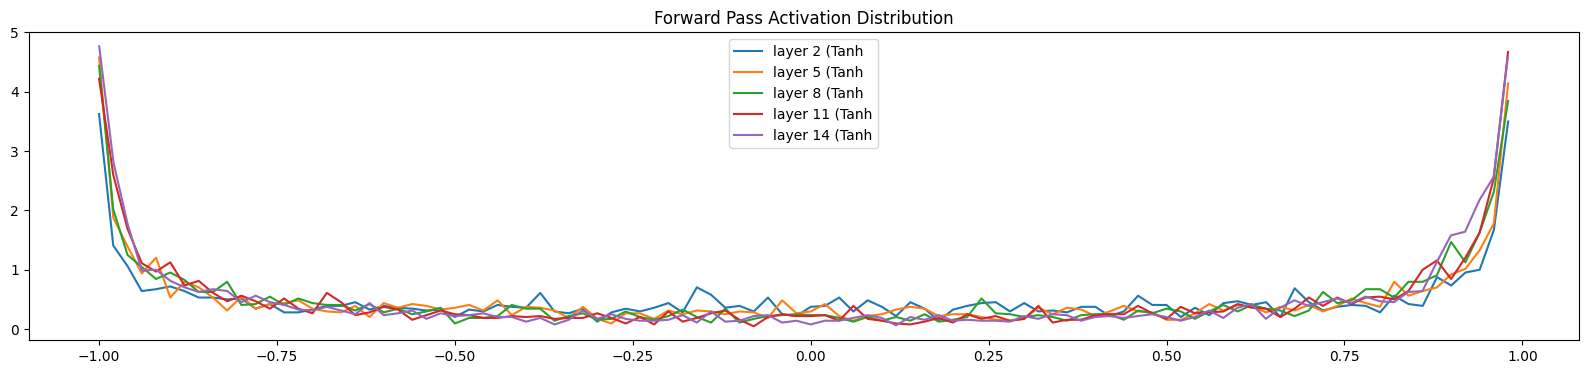

In [ ]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
    if isinstance(layer, Tanh):
        t = layer.out
        print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__}')

plt.legend(legends);
plt.title('Forward Pass Activation Distribution')

layer 2 (      Tanh): mean -0.000000, std 3.682804e-03
layer 5 (      Tanh): mean -0.000000, std 3.489737e-03
layer 8 (      Tanh): mean -0.000000, std 3.604941e-03
layer 11 (      Tanh): mean +0.000000, std 3.117647e-03
layer 14 (      Tanh): mean +0.000000, std 3.502808e-03


Text(0.5, 1.0, 'Activation Layer Gradient Distribution')

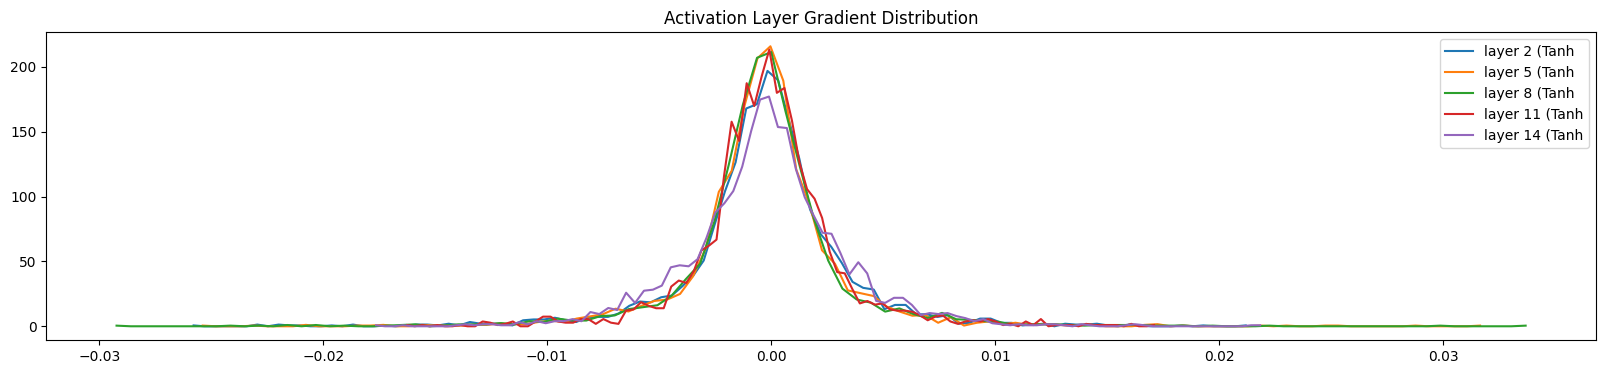

In [ ]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
    if isinstance(layer, Tanh):
        t = layer.out.grad
        print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__}')

plt.legend(legends);
plt.title('Activation Layer Gradient Distribution')

weight   (27, 10) | mean +0.000000 | std 1.841559e-02 | grad:data ratio 1.619721e-02
weight  (30, 100) | mean -0.000044 | std 9.194667e-03 | grad:data ratio 2.290679e-02
weight (100, 100) | mean +0.000048 | std 5.665680e-03 | grad:data ratio 2.324884e-02
weight (100, 100) | mean +0.000033 | std 5.441663e-03 | grad:data ratio 2.262012e-02
weight (100, 100) | mean +0.000047 | std 5.277465e-03 | grad:data ratio 2.292385e-02
weight (100, 100) | mean +0.000001 | std 4.858364e-03 | grad:data ratio 2.253465e-02
weight  (100, 27) | mean -0.000082 | std 7.756864e-03 | grad:data ratio 2.193141e-02


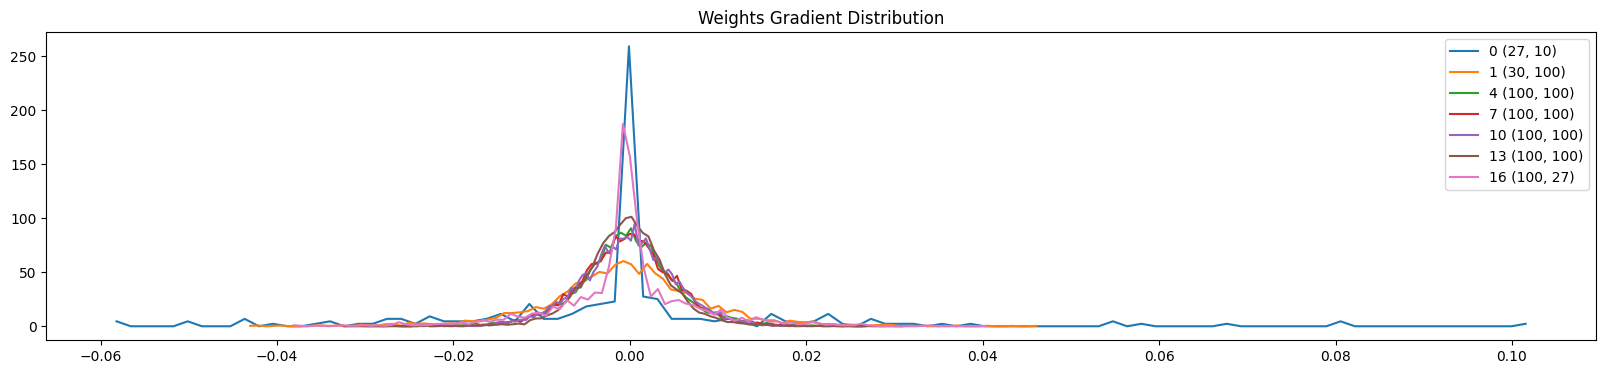

In [ ]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i,p in enumerate(parameters):
    t = p.grad
    if p.ndim == 2:
        print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'{i} {tuple(p.shape)}')

plt.legend(legends)
plt.title('Weights Gradient Distribution');

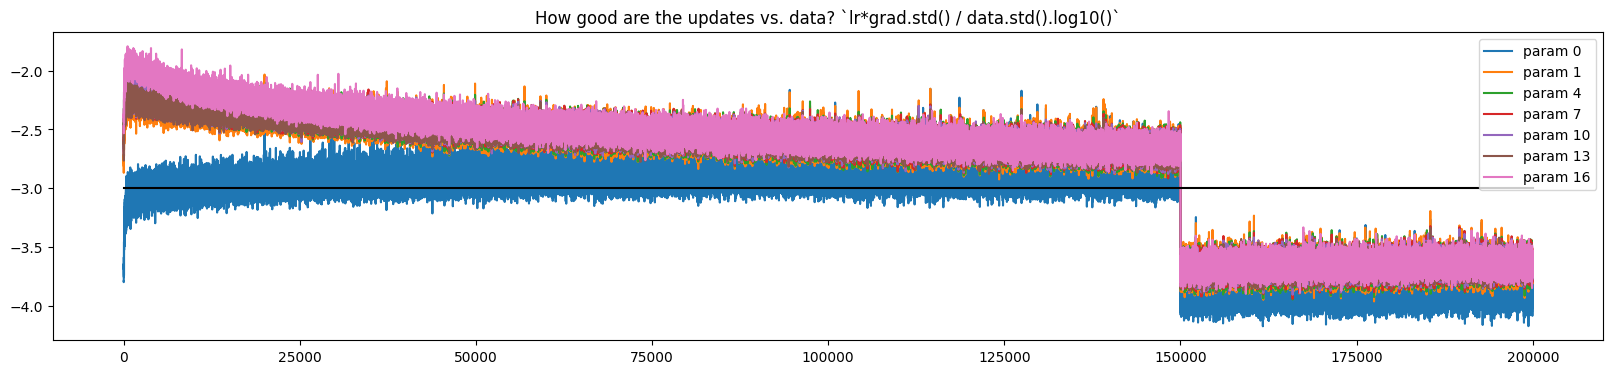

In [ ]:
plt.figure(figsize=(20, 4))
legends = []
for i,p in enumerate(parameters):
    if p.ndim == 2:
        plt.plot([ud[j][i] for j in range(len(ud))])
        legends.append('param %d' % i)

plt.plot([0, len(ud)], [-3, -3], 'k') # these ratios should be ~1e-3, indicate on plot
plt.legend(legends);
plt.title('How good are the updates vs. data? `lr*grad.std() / data.std().log10()`');
# if values are below expected value ~1e-3 then learning rate is too low
# layer parameters should be learning at about the same rate

In [ ]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
    x,y = {
        'train': (X_train, Y_train),
        'validation': (X_val, Y_val),
        'test': (X_test, Y_test),
    }[split]
    emb = C[x] # (N, block_size, n_embd)
    x = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, y)
    print(split, loss.item())

# put layers into eval mode
for layer in layers:
    layer.training = False
split_loss('train')
split_loss('validation')

train 1.999863624572754
validation 2.077087879180908


In [ ]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):

    out = []
    context = [0] * block_size # initialize with all ...
    while True:
        # forward pass the neural net
        emb = C[torch.tensor([context])] # (1,block_size,n_embd)
        x = emb.view(emb.shape[0], -1) # concatenate the vectors
        for layer in layers:
            x = layer(x)
        logits = x
        probs = F.softmax(logits, dim=1)
        # sample from the distribution
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        # shift the context window and track the samples
        context = context[1:] + [ix]
        out.append(ix)
        # if we sample the special '.' token, break
        if ix == 0:
            break

    print(''.join(itos[i] for i in out)) # decode and print the generated word


montaylynn.
see.
mad.
rylla.
emmasiendra.
gradee.
daelin.
shi.
jenneden.
estanaraelyn.
malaia.
nosalbergiaghiel.
kinjo.
jennix.
teriffuna.
geder.
yarun.
eli.
kayshaykella.
halisa.
